In [3]:
# https://www.tensorflow.org/text/tutorials/nmt_with_attention
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

use_builtins = True

class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}
      
    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                           f'    found {rank}: {shape.numpy()}\n'
                           f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                             f"    found: {new_dim}\n"
                             f"    expected: {old_dim}\n")

### Data

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True,
    cache_dir='data-ignored/translation')

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2654208/2638744 [==============================] - 1s 0us/step


In [5]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

targ, inp = load_data(path_to_file)
print(inp[-1])
print(targ[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [6]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:1])
    print()
    print(example_target_batch[:1])
    break


2022-02-18 14:52:02.478638: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor([b'Todos pueden cometer errores.'], shape=(1,), dtype=string)

tf.Tensor([b'Anyone can make mistakes.'], shape=(1,), dtype=string)


In [7]:
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
print(input_text_processor.get_vocabulary()[:10])

output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
print(output_text_processor.get_vocabulary()[:10])
input_vocab = np.array(input_text_processor.get_vocabulary())


example_tokens = input_text_processor(example_input_batch)
print(example_tokens[:3, :10])
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)
print(tokens)

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']
['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']
tf.Tensor(
[[   2   66  414 1635  672    4    3    0    0    0]
 [   2   89    9 1384   35  279    4    3    0    0]
 [   2    9   48  108    4    3    0    0    0    0]], shape=(3, 10), dtype=int64)
['[START]' 'todos' 'pueden' 'cometer' 'errores' '.' '[END]' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '']


### Encoder-decoder model

In [8]:
# Encoder
embedding_dim = 256
units = 1024

class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       # Return the sequence and state
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        # 4. Returns the new sequence and its state.
        return output, state

# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [9]:
# Attention
# dec -> query
# enc -> value
# value_units ~ enc units or units
# query_units ~ dec units
# s -> enc input sequence
# t -> dec input sequence
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()
    
    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights
    
attention_layer = BahdanauAttention(units)
print((example_tokens != 0).shape)

# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length (t), units (attention units)):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length (t), value_seq_length (s)): {attention_weights.shape}')

(64, 22)
Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 22)


In [10]:
# Decoder
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)
        
    def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
            shape_checker = ShapeChecker()
            shape_checker(inputs.new_tokens, ('batch', 't'))
            shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
            shape_checker(inputs.mask, ('batch', 's'))

            if state is not None:
                shape_checker(state, ('batch', 'dec_units'))

            # Step 1. Lookup the embeddings
            vectors = self.embedding(inputs.new_tokens)
            shape_checker(vectors, ('batch', 't', 'embedding_dim'))

            # Step 2. Process one step with the RNN
            rnn_output, state = self.gru(vectors, initial_state=state)

            shape_checker(rnn_output, ('batch', 't', 'dec_units'))
            shape_checker(state, ('batch', 'dec_units'))

            # Step 3. Use the RNN output as the query for the attention over the
            # encoder output.
            context_vector, attention_weights = self.attention(
              query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
            shape_checker(context_vector, ('batch', 't', 'dec_units'))
            shape_checker(attention_weights, ('batch', 't', 's'))

            # Step 4. Eqn. (3): Join the context_vector and rnn_output
            #     [ct; ht] shape: (batch t, value_units + query_units)
            context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

            # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
            attention_vector = self.Wc(context_and_rnn_output)
            shape_checker(attention_vector, ('batch', 't', 'dec_units'))

            # Step 5. Generate logit predictions:
            logits = self.fc(attention_vector)
            shape_checker(logits, ('batch', 't', 'output_vocab_size'))

            return DecoderOutput(logits, attention_weights), state

decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

# Usage example
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

# Sample a token according to the logits and decode the token as the first word of the output. First prediction
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

# Second prediction
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)
[['pistol']
 ['gonna']
 ['coming']
 ['bench']
 ['every']]
[['europe']
 ['pockets']
 ['stabbed']
 ['collection']
 ['mustnt']]


### Training

In [14]:
import datetime

class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)
    
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)
    
    def _preprocess(self, input_text, target_text):
        self.shape_checker(input_text, ('batch',))
        self.shape_checker(target_text, ('batch',))

        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        self.shape_checker(input_tokens, ('batch', 's'))
        self.shape_checker(target_tokens, ('batch', 't'))

        # Convert IDs to masks.
        input_mask = input_tokens != 0
        self.shape_checker(input_mask, ('batch', 's'))

        target_mask = target_tokens != 0
        self.shape_checker(target_mask, ('batch', 't'))

        return input_tokens, input_mask, target_tokens, target_mask
    
    def _train_step(self, inputs):
        input_text, target_text = inputs  

        (input_tokens, input_mask,
        target_tokens, target_mask) = self._preprocess(input_text, target_text)

        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)
            self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
            self.shape_checker(enc_state, ('batch', 'enc_units'))

            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of
            # units.
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length-1):
              # Pass in two tokens from the target sequence:
              # 1. The current input to the decoder.
              # 2. The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                         enc_output, dec_state)
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Apply an optimization step
        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        # Return a dict mapping metric names to current value
        return {'batch_loss': average_loss}
    
    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        # Run the decoder one step.
        decoder_input = DecoderInput(new_tokens=input_token,
                                   enc_output=enc_output,
                                   mask=input_mask)

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
        self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
        self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        self.shape_checker(dec_state, ('batch', 'dec_units'))

        # `self.loss` returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state 
    
    # tf function is faster
    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)
    
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

start_time = datetime.datetime.now()
for n in range(3):
    print(translator.train_step([example_input_batch, example_target_batch]))
print(datetime.datetime.now() - start_time)

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6058345>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5738454>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5131044>}
0:00:09.292453


In [17]:
translator.use_tf_function = True
start_time = datetime.datetime.now()
for n in range(3):
    print(translator.train_step([example_input_batch, example_target_batch]))
print(datetime.datetime.now() - start_time)

# reset model
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9765253>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9597201>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.989764>}
0:00:05.184365


In [18]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
1859/1859 [==============================] - 2381s 1s/step - batch_loss: 2.0793
Epoch 2/3
1859/1859 [==============================] - 2583s 1s/step - batch_loss: 1.0463
Epoch 3/3
1859/1859 [==============================] - 2349s 1s/step - batch_loss: 0.8151


### Translation

In [20]:
class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))
        
    def tokens_to_text(self, result_tokens):
        shape_checker = ShapeChecker()
        shape_checker(result_tokens, ('batch', 't'))
        result_text_tokens = self.output_token_string_from_index(result_tokens)
        shape_checker(result_text_tokens, ('batch', 't'))

        result_text = tf.strings.reduce_join(result_text_tokens,
                                           axis=1, separator=' ')
        shape_checker(result_text, ('batch'))

        result_text = tf.strings.strip(result_text)
        shape_checker(result_text, ('batch',))
        return result_text
    
    def sample(self, logits, temperature):
        shape_checker = ShapeChecker()
        # 't' is usually 1 here.
        shape_checker(logits, ('batch', 't', 'vocab'))
        shape_checker(self.token_mask, ('vocab',))

        token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
        shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

        # Set the logits for all masked tokens to -inf, so they are never chosen.
        logits = tf.where(self.token_mask, -np.inf, logits)

        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else: 
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature,
                                            num_samples=1)

        shape_checker(new_tokens, ('batch', 't'))
        return new_tokens
    
    def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                                     enc_output=enc_output,
                                     mask=(input_tokens!=0))

            dec_result, dec_state = self.decoder(dec_input, state=dec_state)

            attention.append(dec_result.attention_weights)

            new_tokens = self.sample(dec_result.logits, temperature)

            # If a sequence produces an `end_token`, set it `done`
            done = done | (new_tokens == self.end_token)
            # Once a sequence is done it only produces 0-padding.
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

            # Collect the generated tokens
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Convert the list of generates token ids to a list of strings.
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}

        
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate_unrolled(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

/var/folders/g9/6qklj4h53bv0c1rjnffg7bmw0000gp/T/ipykernel_80609/3155067552.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


its very cold here .
this is my life .



[1.0000001  0.99999994 1.         1.         1.         1.        ]


NameError: name 'plot_attention' is not defined

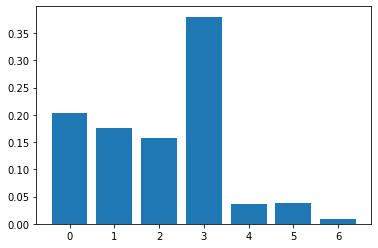

In [21]:
a = result['attention'][0]

print(np.sum(a, axis=-1))
_ = plt.bar(range(len(a[0, :])), a[0, :])


i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])